# NN with only Convolution Layers for 3 Track Events (find hit location)

In [1]:

# System imports
import math
from __future__ import print_function

# Standard imports
import sys
import numpy as np
from tempfile import TemporaryFile

# Python Externa Imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Keras Imports
from keras import models
from keras import layers
import keras.backend as K
from keras.regularizers import l2


# Local imports
from local_modules import generate_data, track_hit_coords, drawMulti_from_params_pix, draw_from_params, get_Alist_pulls

# Magic
%matplotlib inline

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


Using cuDNN version 5105 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:04:00.0)


In [2]:
#data = np.load('/bigdata/atsaris/train_data.npz')
data = np.load('/bigdata/atsaris/new/data6trk_256.npz')
#data = np.load('/home/atsaris/hepTrack_newY_test/23_04_2017/train_data_test.npz') # use it for test

In [3]:
# Model
def build_model_2():
    """Test model.  Consists of several convolutional layers followed by dense layers and an output layer"""
    input_layer = layers.Input(shape=(1, num_det_layers, det_layer_size, det_layer_size))
    layer = layers.Convolution3D(8, 3, 3, 3, border_mode='same')(input_layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution3D(8, 3, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.MaxPooling3D(pool_size=(2,2,2))(layer)
    layer = layers.Convolution3D(16, 3, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution3D(16, 3, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Flatten()(layer)
    layer = layers.Dense(1000)(layer)
    layer = layers.RepeatVector(max_tracks)(layer)
    layer = layers.LSTM(1000, return_sequences=True)(layer)
    output_layer = layers.TimeDistributed(layers.Dense(2*num_det_layers))(layer)
    model = models.Model(input=input_layer, output=output_layer)
    model.compile(loss='mean_squared_error', optimizer='Adam', sample_weight_mode="temporal", metrics=['accuracy'])
    return model

Max_tracks:  6
Num_tracks:  3
epoch_size:  25600
num_epochs:  10

[[  5.12290351  20.97678924   5.40904012  20.06131989   5.69517672
   19.14585054   5.98131332  18.23038119   6.26744992  17.31491184
    6.55358652  16.39944249   6.83972313  15.48397314   7.12585973
   14.56850379   7.41199633  13.65303444   7.69813293  12.73756509]
 [ 29.03813133  27.30877704  26.37332653  26.45359048  23.70852172
   25.59840392  21.04371692  24.74321736  18.37891212  23.8880308
   15.71410732  23.03284424  13.04930252  22.17765768  10.38449772
   21.32247112   7.71969292  20.46728456   5.05488812  19.612098  ]
 [ 30.03411837  15.09927486  27.5564043   16.71431357  25.07869023
   18.32935229  22.60097615  19.944391    20.12326208  21.55942972
   17.645548    23.17446843  15.16783393  24.78950715  12.69011985
   26.40454586  10.21240578  28.01958458   7.7346917   29.63462329]
 [-99.         -99.         -99.         -99.         -99.         -99.
  -99.         -99.         -99.         -99.         -9

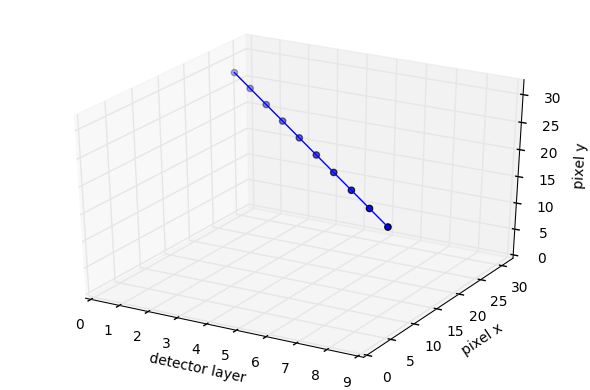

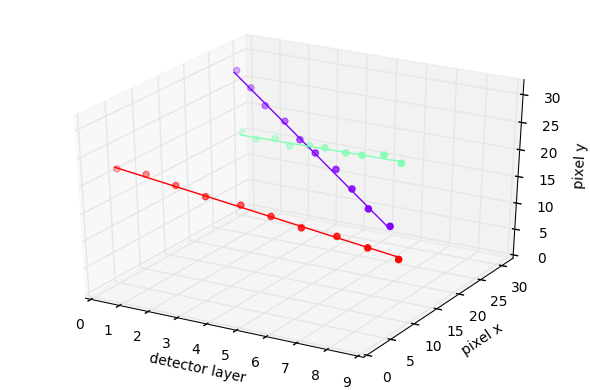

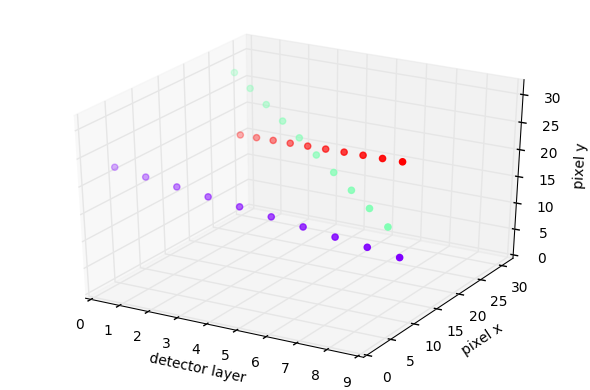

In [4]:
# Configuration
num_det_layers = data['num_det_layers']
det_layer_size = data['det_layer_size']
num_seed_layers = 0
avg_bkg_tracks = 0
noise_prob = 0.0
det_shape = (num_det_layers, det_layer_size, det_layer_size)

max_tracks = data['max_tracks']
num_tracks = data['num_tracks']

# Training parameters
batch_size = data['batch_size']
epoch_size = data['epoch_size']
num_epochs = data['num_epochs']

print("Max_tracks: ", max_tracks)
print("Num_tracks: ", num_tracks)
print("epoch_size: ", epoch_size)
print("num_epochs: ", num_epochs)

events = data['events']
targets_par = data['target_slope']
targets_pix = data['target_slope_pix']
weights = data['weights']

# Make sure input to NN is OK
test_index = np.random.randint(epoch_size)
test_event = events[test_index]
test_target_par = targets_par[test_index]
test_target_pix = targets_pix[test_index]
print("")
#print(test_event, "\n")
print(test_target_pix, "\n")
print(test_target_par)
draw_from_params(test_target_par, num_det_layers, det_layer_size)
drawMulti_from_params_pix(num_tracks, test_target_par, num_det_layers, det_layer_size, True)
drawMulti_from_params_pix(num_tracks, test_target_pix, num_det_layers, det_layer_size)

In [5]:
# Train the model
model_2 = build_model_2()
history = model_2.fit(events, targets_pix, batch_size=batch_size, nb_epoch=num_epochs, 
           validation_split=0.1, sample_weight=weights)

Train on 23040 samples, validate on 2560 samples
Epoch 1/10
23040/23040 [==============================] - 14s - loss: 71.0149 - acc: 0.2025 - val_loss: 57.2130 - val_acc: 0.4253
Epoch 2/10
23040/23040 [==============================] - 13s - loss: 56.5242 - acc: 0.4866 - val_loss: 56.7057 - val_acc: 0.6169
Epoch 3/10
23040/23040 [==============================] - 13s - loss: 55.6775 - acc: 0.5264 - val_loss: 55.8021 - val_acc: 0.6293
Epoch 4/10
23040/23040 [==============================] - 13s - loss: 54.9378 - acc: 0.4298 - val_loss: 54.8500 - val_acc: 0.0118
Epoch 5/10
23040/23040 [==============================] - 13s - loss: 54.1956 - acc: 0.5124 - val_loss: 54.1202 - val_acc: 0.5385
Epoch 6/10
23040/23040 [==============================] - 13s - loss: 53.2781 - acc: 0.5441 - val_loss: 53.0023 - val_acc: 0.5132
Epoch 7/10
23040/23040 [==============================] - 13s - loss: 52.0662 - acc: 0.4749 - val_loss: 51.6852 - val_acc: 0.5199
Epoch 8/10
23040/23040 [=================

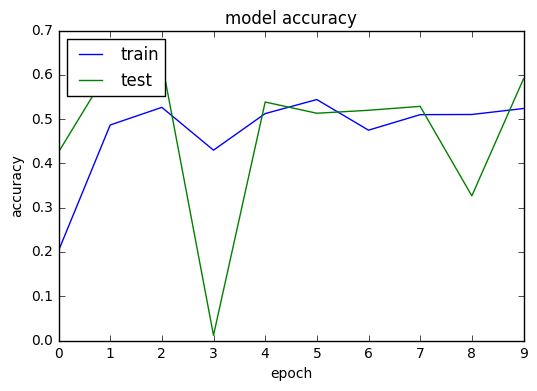

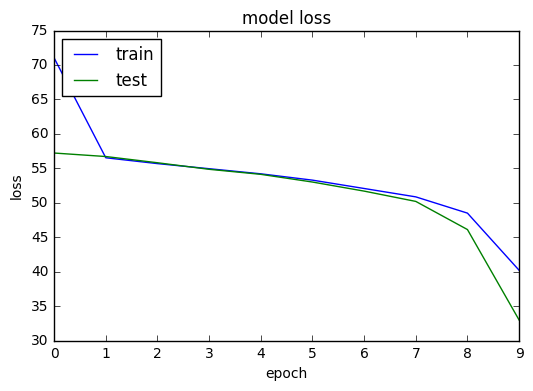

In [6]:
# Plot the accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [7]:
test_data = np.load('/bigdata/atsaris/new/test6trk_256.npz')
train_events = test_data['events']
train_targets_slope = test_data['target_slope']
train_targets_slope_pix = test_data['target_slope_pix']
train_weights = test_data['weights']

In [8]:
for i in range(0, 2*num_det_layers):
    mu, sigma = get_Alist_pulls(model_2, 1000, train_events, train_weights, train_targets_slope_pix, i, False)
    print("pixel: ", mu, sigma)

pixel:  0.855218649361 3.78556605419
pixel:  -0.51450383612 7.67187574681
pixel:  0.635394946458 3.41144096225
pixel:  -0.287048713958 6.68335106452
pixel:  0.706696373528 3.31108145904
pixel:  -0.32212128793 5.89767316352
pixel:  0.574372430632 3.47292805085
pixel:  -0.350740637878 5.3206718675
pixel:  0.393362283064 3.87353201916
pixel:  -0.343972172986 5.0119584903
pixel:  0.134649230716 4.49632228338
pixel:  -0.351467838845 5.11294905569
pixel:  0.222245486339 5.17545384655
pixel:  -0.25020043285 5.52691580436
pixel:  0.147104453647 5.97535809393
pixel:  -0.326826152071 6.22122784467
pixel:  -0.0512898275775 6.83428238992
pixel:  -0.216323586837 7.07958884963
pixel:  -0.15326120749 7.67819210843
pixel:  -0.0609217742755 8.06471520806


[[  2.92462659  19.96076965   5.06778812  19.21479797   5.8416729
   19.0197506    7.11498737  18.4695797    8.41151142  17.77384949
   10.03901386  17.28078079  10.91637421  17.05526924  12.23131275
   17.43535614  13.5129385   15.92210484  14.42666721  14.84346294]
 [  9.08304691  23.3955555   10.47871304  22.4864006   10.52041721
   21.86355972  11.13305187  21.53011322  12.14201736  20.41809082
   13.18165684  20.16293907  13.41936111  19.45343781  14.10111904
   19.57485962  15.39426231  17.9587841   15.34700966  16.98752975]
 [ 13.82554436  22.0645237   14.63367558  21.00098228  14.00628471
   19.86387825  13.9292984   19.79764748  14.16663074  18.37495041
   14.34240818  18.38598442  13.47248268  17.27953911  14.01499462
   17.11346054  14.70162582  15.8634491   13.49231148  15.11828613]]


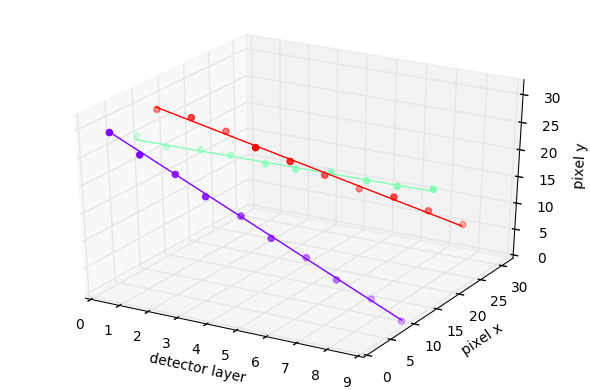

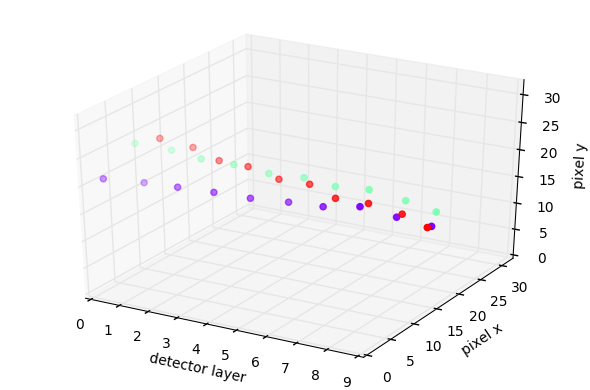

In [21]:
test_index = np.random.randint(0,test_data['epoch_size'])
# Draw Truth
test_weights = train_weights[test_index].astype(np.bool_)
test_a_tmp = train_targets_slope_pix[test_index][test_weights]
test_a = train_targets_slope[test_index][test_weights]
drawMulti_from_params_pix(num_tracks, test_a, num_det_layers, det_layer_size, True)
#drawMulti_from_params_pix(num_tracks, test_a_tmp, num_det_layers, det_layer_size)

# Draw Prediction
test_event = train_events[test_index]
test_pred = model_2.predict(np.asarray([test_event]))[0][test_weights]
print(test_pred)
drawMulti_from_params_pix(num_tracks, test_pred, num_det_layers, det_layer_size)